# Clase 2 — Fundamentos Técnicos de Machine Learning (Teoría + Práctica)
**Instructor:** Josef Rodriguez  
**Objetivo:** Entender ML como optimización (\(\hat y=f(X)\)) y construir **dos modelos reales**:
1) **Clasificación** (Supervisado): predecir una clase  
2) **Regresión** (Supervisado): predecir un valor numérico  

> En proyectos reales, no te pagan por entrenar modelos… te pagan porque funcionen en producción.

---
**Cómo usar este notebook (1 minuto):**
- Ejecuta de arriba hacia abajo.
- Las celdas de **descarga** traen datasets desde internet en una línea.
- Si alguna celda falla por conexión, vuelve a ejecutar o prueba desde Google Colab.


## Agenda (2 horas)
### 1) Conceptos clave (10–15 min)
- ML como función: \(\hat y = f(X)\)
- Train/Test y generalización
- Overfitting vs Underfitting
- Métricas: clasificación vs regresión

### 2) Práctica guiada (45–55 min)
- Dataset de **Clasificación** (Titanic)
- Dataset de **Regresión** (House Prices - Ames / o alternativa)

### 3) Extras (opcional)
- Pipelines (ColumnTransformer)
- Cross-validation
- Evitar data leakage


In [1]:
# ======================================
# 0. Setup: librerías
# ======================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

import matplotlib.pyplot as plt


## 1) Mini teoría en 5 slides (en texto)

### 1.1 ¿Qué es ML?
Un modelo es una **función** que transforma variables (**features**) en una salida:
\[
\hat{y} = f(X)
\]
- \(X\): matriz de features
- \(y\): target (verdad)
- \(\hat y\): predicción
- Entrenar = **ajustar parámetros** para minimizar una pérdida (error).

### 1.2 ¿Por qué train/test?
Si evaluamos con los mismos datos que entrenamos, el modelo puede **memorizar**.
- **Train**: “ejercicios del libro”
- **Test**: “examen con preguntas nuevas”
- (Opcional) **Validation/OOT**: “concurso” (distribución diferente o tiempo futuro)

### 1.3 Overfitting vs Underfitting
- **Underfitting**: modelo muy simple, no aprende ni en train.
- **Overfitting**: modelo muy complejo, “aprende ruido” y falla en test.
- **Generalización**: el punto ideal (aprende patrón, no ruido).

### 1.4 Métricas (según tipo de y)
**Clasificación (y categórica):** Accuracy, Precision, Recall, F1  
**Regresión (y numérica):** MAE, RMSE, R²

### 1.5 Data Leakage (alerta)
Ocurre si el modelo ve información del futuro o del target “camuflada” en features.
Ejemplos: variables calculadas con el target, uso incorrecto de todo el dataset antes del split, etc.


# 2) Caso 1 — Clasificación (Supervisado)
Vamos a predecir **Survived** (0/1) usando el dataset **Titanic**.

- Dataset clásico, con variables numéricas y categóricas.
- Buen ejemplo para ver: imputación, one-hot encoding, métricas (precision/recall).


In [2]:
# ======================================
# 2.1 Descargar dataset de internet (1 celda)
# ======================================
# Fuente: Titanic dataset (Kaggle mirror / GitHub raw)
url_titanic = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df_cls = pd.read_csv(url_titanic)

df_cls.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 2.2 Revisión rápida
print(df_cls.shape)
df_cls.info()


(891, 12)
<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


In [4]:
# 2.3 Definir target (y) y features (X)
# Target: Survived (0/1)
target = "Survived"

X = df_cls.drop(columns=[target])
y = df_cls[target]

# Nota: 'Name' y 'Ticket' suelen ser alta cardinalidad; para un baseline, las podemos eliminar.
cols_drop = ["Name", "Ticket", "Cabin"]  # Cabin suele tener muchos nulos
X = X.drop(columns=[c for c in cols_drop if c in X.columns])

X.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S


In [5]:
# 2.4 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (712, 8)  Test: (179, 8)


In [6]:
# 2.5 Preprocesamiento (numérico vs categórico) + Pipeline
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [7]:
# 2.6 Modelo baseline: Logistic Regression
clf_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred_lr))
print("Precision:", precision_score(y_test, pred_lr))
print("Recall:", recall_score(y_test, pred_lr))
print("F1:", f1_score(y_test, pred_lr))


Accuracy: 0.8044692737430168
Precision: 0.7833333333333333
Recall: 0.6811594202898551
F1: 0.7286821705426356


/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix:
 [[97 13]
 [22 47]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



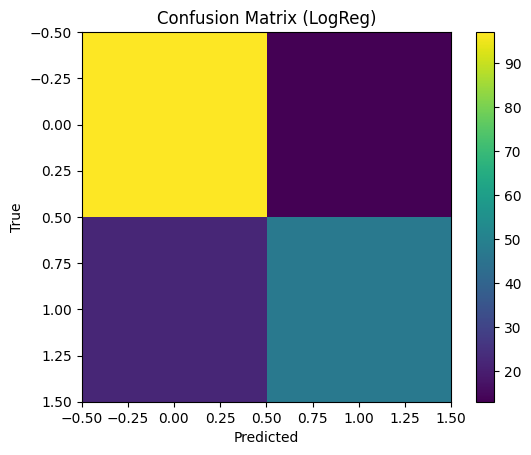

In [8]:
# 2.7 Confusion Matrix + Report
cm = confusion_matrix(y_test, pred_lr)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, pred_lr))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (LogReg)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


In [9]:
# 2.8 Segundo modelo: RandomForestClassifier (baseline fuerte)
clf_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

clf_rf.fit(X_train, y_train)
pred_rf = clf_rf.predict(X_test)

print("RandomForest — métricas")
print("Accuracy:", accuracy_score(y_test, pred_rf))
print("Precision:", precision_score(y_test, pred_rf))
print("Recall:", recall_score(y_test, pred_rf))
print("F1:", f1_score(y_test, pred_rf))


RandomForest — métricas
Accuracy: 0.8100558659217877
Precision: 0.7868852459016393
Recall: 0.6956521739130435
F1: 0.7384615384615385


In [10]:
# 2.9 (Opcional) Cross-validation en train (para estimar estabilidad)
# Nota: CV solo sobre TRAIN para no "mirar" el test.
scores = cross_val_score(clf_lr, X_train, y_train, cv=5, scoring="f1")
print("F1 CV mean:", scores.mean(), "std:", scores.std())


F1 CV mean: 0.7227090387827892 std: 0.03977059580114902


/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josefrodriguez/repos/ML_course/clases_ml/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    h

## ✅ Cierre Clasificación
- Ya tienes un pipeline reproducible: **imputación + one-hot + modelo**
- Evaluaste con métricas correctas (no solo accuracy)
- Comparaste modelos

**Tarea sugerida (clasificación):**
1) Quita/pon variables (ej. mantener `Name` y extraer el título: Mr/Mrs/Miss).  
2) Prueba `GradientBoosting` o `XGBoost` (si lo tienen instalado).  
3) Optimiza umbral: `predict_proba` y cambia el cutoff (0.4, 0.6, etc.).


# 3) Caso 2 — Regresión (Supervisado)
Ahora vamos a predecir una variable **numérica**.

Usaremos **House Prices (Ames)** en versión simple (csv público).  
Target: **SalePrice** (precio de venta).

> Si el link no responde por conexión, deja este bloque y usa la alternativa: California Housing (sklearn).


In [11]:
# ======================================
# 3.1 Descargar dataset de internet (1 celda)
# ======================================
from sklearn.datasets import fetch_california_housing

cal = fetch_california_housing(as_frame=True)
df_reg = cal.frame

df_reg.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
print(df_reg.shape)
df_reg.describe()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [13]:
# 3.2 Revisión rápida
print(df_reg.shape)
df_reg[["MedHouseVal"]].describe()


(20640, 9)


,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


In [14]:
target_reg = "MedHouseVal"

Xr = df_reg.drop(columns=[target_reg])
yr = df_reg[target_reg]

from sklearn.model_selection import train_test_split

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr,
    test_size=0.2,
    random_state=42
)

print("Train:", Xr_train.shape)
print("Test:", Xr_test.shape)

Train: (16512, 8)
Test: (4128, 8)


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

reg_lin = Pipeline(steps=[
    ("preprocess", numeric_transformer),
    ("model", LinearRegression())
])

reg_lin.fit(Xr_train, yr_train)

pred_lin = reg_lin.predict(Xr_test)

mae = mean_absolute_error(yr_test, pred_lin)
rmse = np.sqrt(mean_squared_error(yr_test, pred_lin))
r2 = r2_score(yr_test, pred_lin)

print("===== Linear Regression =====")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")


===== Linear Regression =====
MAE:  0.5332
RMSE: 0.7456
R2:   0.5758


In [17]:
# 3.6 Segundo modelo: RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

reg_rf = Pipeline(steps=[
    ("preprocess", numeric_transformer),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
reg_rf.fit(Xr_train, yr_train)

# Predicción
pred_rf = reg_rf.predict(Xr_test)

# Métricas
mae_rf = mean_absolute_error(yr_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(yr_test, pred_rf))
r2_rf = r2_score(yr_test, pred_rf)

print("===== Random Forest Regressor =====")
print(f"MAE:  {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R2:   {r2_rf:.4f}")


===== Random Forest Regressor =====
MAE:  0.3265
RMSE: 0.5035
R2:   0.8066


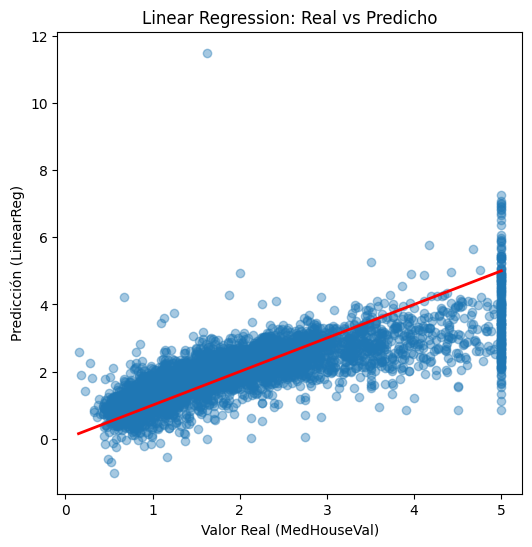

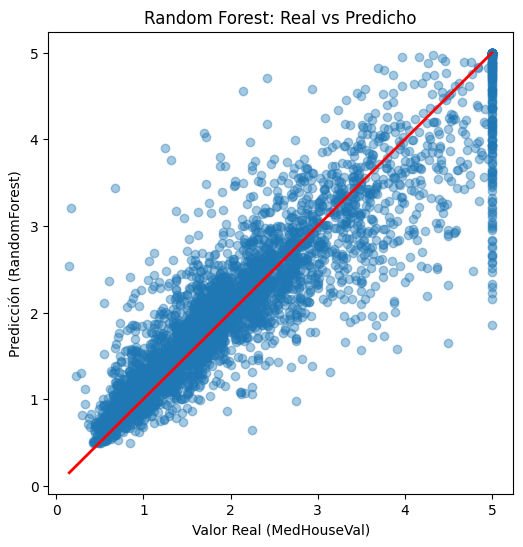

In [18]:
# 3.7 Visual: Predicción vs Real (California Housing)
import matplotlib.pyplot as plt
import numpy as np

# ---------- Linear Regression ----------
plt.figure(figsize=(6,6))
plt.scatter(yr_test, pred_lin, alpha=0.4)
plt.plot([yr_test.min(), yr_test.max()],
         [yr_test.min(), yr_test.max()],
         color="red", linewidth=2)  # Línea perfecta y=x

plt.xlabel("Valor Real (MedHouseVal)")
plt.ylabel("Predicción (LinearReg)")
plt.title("Linear Regression: Real vs Predicho")
plt.show()


# ---------- Random Forest ----------
plt.figure(figsize=(6,6))
plt.scatter(yr_test, pred_rf, alpha=0.4)
plt.plot([yr_test.min(), yr_test.max()],
         [yr_test.min(), yr_test.max()],
         color="red", linewidth=2)

plt.xlabel("Valor Real (MedHouseVal)")
plt.ylabel("Predicción (RandomForest)")
plt.title("Random Forest: Real vs Predicho")
plt.show()


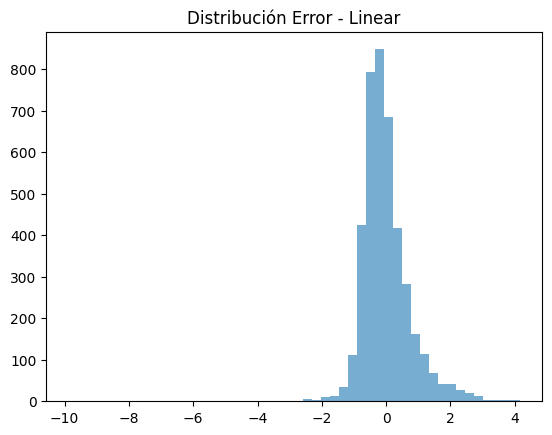

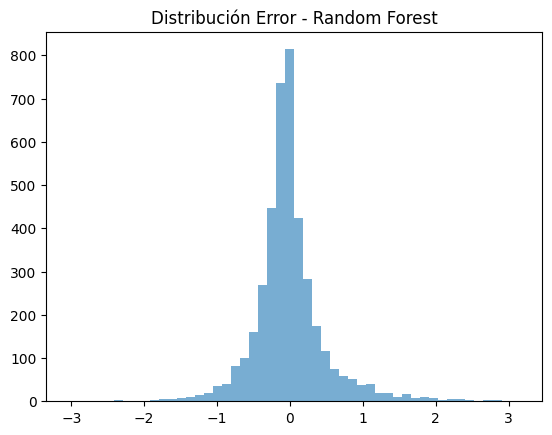

In [19]:
residuals_lin = yr_test - pred_lin
residuals_rf = yr_test - pred_rf

plt.figure()
plt.hist(residuals_lin, bins=50, alpha=0.6)
plt.title("Distribución Error - Linear")
plt.show()

plt.figure()
plt.hist(residuals_rf, bins=50, alpha=0.6)
plt.title("Distribución Error - Random Forest")
plt.show()

In [20]:
import pandas as pd

results = pd.DataFrame({
    "Modelo": ["Linear Regression", "Random Forest"],
    "MAE": [mae, mae_rf],
    "RMSE": [rmse, rmse_rf],
    "R2": [r2, r2_rf]
})

results

,Modelo,MAE,RMSE,R2
0,Linear Regression,0.533200,0.745581,0.575788
1,Random Forest,0.326459,0.503485,0.806551


In [21]:
best_model = results.sort_values(by="RMSE").iloc[0]["Modelo"]

print("El mejor modelo según RMSE es:", best_model)

El mejor modelo según RMSE es: Random Forest


In [22]:
# 3.8 (Alternativa sin internet) California Housing (sklearn)
# Si tu entorno no permite descargar CSV, puedes usar este dataset integrado.
# Descomenta si lo necesitas.

# from sklearn.datasets import fetch_california_housing
# cal = fetch_california_housing(as_frame=True)
# df_cal = cal.frame
# Xc = df_cal.drop(columns=["MedHouseVal"])
# yc = df_cal["MedHouseVal"]
# Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
# print(df_cal.shape)


## ✅ Cierre Regresión
- Cambió la **métrica**: ahora medimos error numérico (MAE/RMSE) y explicación (R²).
- Mismo patrón de trabajo: split → preprocess → fit → evaluar.

**Tarea sugerida (regresión):**
1) Transforma el target: `np.log1p(SalePrice)` y vuelve a entrenar.  
2) Prueba `GradientBoostingRegressor`.  
3) Evalúa con cross-validation en train.


# 4) Checklist de lo que ya sabes (auto-evaluación)
Responde sin mirar:
1) ¿Qué es **X** y qué es **y**?  
2) ¿Qué significa **fit**?  
3) ¿Por qué existe el **test set**?  
4) ¿Qué es **overfitting**?  
5) ¿Qué métricas usas en **clasificación** vs **regresión**?  
6) ¿Qué es **data leakage** (en una frase)?

---
**Siguiente clase (Clase 3):** EDA + Feature Engineering + Validación más seria (CV + baseline + comparación).  
